In [35]:
# The trust-region Newton method applied to LJ7 cluster in 3D 

import numpy as np
import scipy
import matplotlib.pyplot as plt
from math import sqrt
from LJhelpers import *
from matplotlib.ticker import MaxNLocator

In [36]:
# Set up the initial configuration

# Four lical minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid 
# f2 = -15.93504306 Capped octahedron 
# f3 = -15.59321094 Tricapped tetrahedron 
# f4 = -15.53306005 Bicapped trigonal bipyramid

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.


In [136]:
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 200 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for trust region
Delta_max = 5 # the max trust-region radius
Delta_min = 1e-12 # the minimal trust-region radius
Delta = 1 # the initial radius
eta = 0.1 # step rejection parameter
subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
tol_sub = 1e-1 # relative tolerance for the subproblem
rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius

def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p

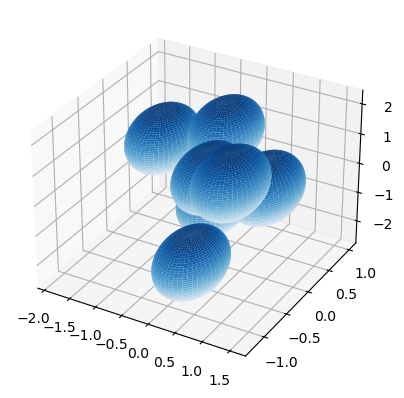

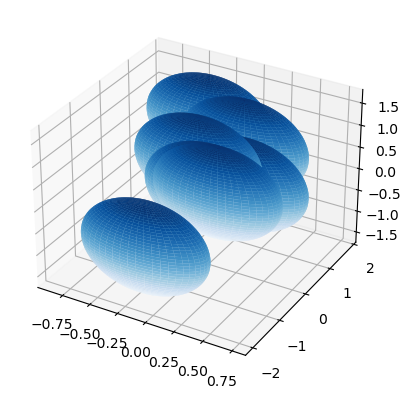

LJpot =  99560408757540.5


In [137]:
# select the initial configuration
model = 0
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x),0.5*rstar)
print("LJpot = ",LJpot(x))

In [140]:
# initialization
f = LJpot(x)
g = LJgrad(x)
norm_g = np.linalg.norm(g)
print("Initially, f = ",f,", ||grad f|| = ",norm_g)

fvals = np.zeros(iter_max)
fvals[0] = f
ngvals = np.zeros(iter_max)
ngvals[0] = norm_g
Delta = 1 # the initial trust region radius
I = np.eye(np.size(x),dtype = float)

iter = 1

Initially, f =  99560408757540.5 , ||grad f|| =  1.561721265881535e+16


In [128]:
def dogleg_method(Hk, gk, Bk, trust_radius):
    gk = LJgrad(x)
    Bk = LJhess(x)
    Hk = np.linalg.inv(Bk)

    pB = -np.dot(Hk, gk)
    norm_pB = sqrt(np.dot(pB, pB))

    # Test if the full step is within the trust region.
    if norm_pB <= Delta:
        return pB

    # Compute the Cauchy point.
    # This is the predicted optimum along the direction of steepest descent.
    pU = - (np.dot(gk, gk) / np.dot(gk.T, np.dot(Bk, gk))) * gk
    dot_pU = np.dot(pU, pU)
    norm_pU = sqrt(dot_pU)
    # If the Cauchy point is outside the trust region,
    # then return the point where the path intersects the boundary
    if norm_pU >= Delta:
        return Delta * pU / norm_pU

    # Find the solution to the scalar quadratic equation
    # Compute the intersection of the trust region boundary
    # and the line segment connecting the Cauchy and Newton points
    # This requires solving a quadratic equation
    # ||p_u + tau*(p_b - p_u)||**2 == trust_radius**2
    # Solve this for positive time t using the quadratic formula
    pB_pU = pB - pU
    dot_pB_pU = np.dot(pB_pU, pB_pU)
    dot_pU_pB_pU = np.dot(pU, pB_pU)
    fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - Delta**2)
    tau = (-dot_pU_pB_pU + sqrt(fact)) / dot_pB_pU
    # Decide on which part of the trajectory to take
    
    return pU + tau * pB_pU

Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept


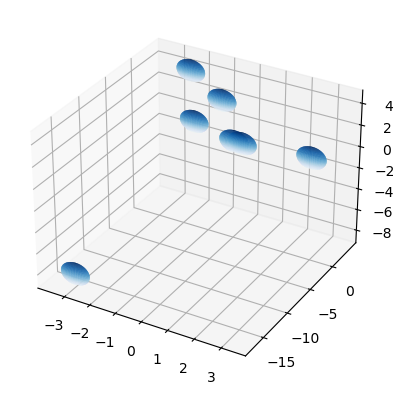

Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept
Accept


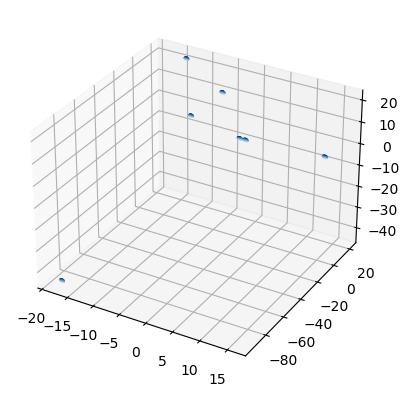

Accept
Accept


In [141]:
# start minimization
# choose algorithm
# direction = 0: Dogleg
# direction = 1: Newton
direction = 0

# the main trust-region cycle
while (norm_g > tol and iter < iter_max):      
    gk = LJgrad(x)
    B = LJhess(x)
    Hk = np.linalg.inv(B)
    flag_boundary = 0 
    
    # Dogleg
    if (direction == 0):
        eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
        if (eval_min > 0):
            p = dogleg_method(Hk, gk, B, Delta)
        
        else:
            lam_min = np.maximum(-eval_min,0.0)
            lam = lam_min + 1
        
            p = dogleg_method(Hk, gk, B+lam*I, Delta)
            
        if np.linalg.norm(p) == Delta:
            flag_boundary = 1
    
    # Newton
    elif (direction == 1):
        # solve the constrained minimization problem 

        # check if B is SPD
        eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
        j_sub = 0
        if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g 
            p = scipy.linalg.solve(B,-g)
            p_norm = np.linalg.norm(p)
            if( p_norm > Delta ): # else: we are done with solbing the subproblem
                flag_boundary = 1        
        else: # B is not SPD
            flag_boundary = 1

        if( flag_boundary == 1 ): # solution lies on the boundary
            # added to B to ensure it is SPD
            lam_min = np.maximum(-eval_min,0.0)
            lam = lam_min + 1

            R = scipy.linalg.cholesky(B+lam*I,lower = False)
            flag_subproblem_success = 0;
            while( j_sub < subproblem_iter_max ):
                j_sub = j_sub + 1;
                p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
                p = scipy.linalg.solve_triangular(R,p,lower = False)
                p_norm = np.linalg.norm(p)
                dd = np.absolute(p_norm - Delta)
                if( dd < tol_sub*Delta ):
                    flag_subproblem_success = 1
                    break
                q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
                q_norm = np.linalg.norm(q);
                dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
                lam_new = lam + dlam;
                if (lam_new > lam_min):
                    lam = lam_new
                else:
                    lam = 0.5*(lam + lam_min)
                R = scipy.linalg.cholesky(B+lam*I,lower = False)

            if( flag_subproblem_success == 0 ):
                p = cauchy_point(B,g,Delta)
            
    # assess the progress
    xnew = x + p
    fnew = LJpot(xnew)
    gnew = LJgrad(xnew)
    mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
    rho = (f - fnew)/(f - mnew+1e-14)
    
    # adjust the trust region
    if( rho < rho_bad ):
        Delta = np.maximum(0.25*Delta,Delta_min)
    else:
        if(  rho > rho_good and flag_boundary == 1 ):
            Delta = np.minimum(Delta_max, 2*Delta)
    
    # accept or reject step
    if( rho > eta ):  # accept step          
        x = xnew
        f = fnew
        g = gnew
        norm_g = np.linalg.norm(g)
        if direction==0:
                print('Accept')
        else:
            print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
    else:
        if direction==0:
            print('Reject')
        else:
            print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
    if( iter % 20 == 19 ):
        # restore all coordinates
        xyz = LJvector2array(x)
        drawconf(xyz,0.5*rstar)
    fvals[iter] = f
    ngvals[iter] = norm_g
    iter = iter + 1




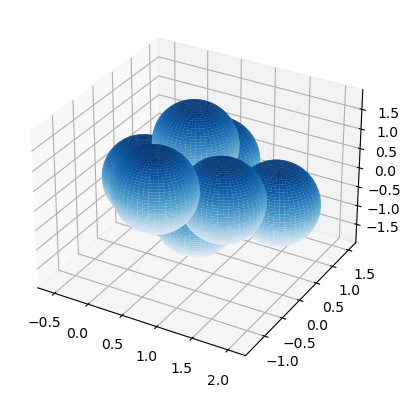

In [123]:
# visualize the final configuration and plot graphs
xyz = LJvector2array(x)    
drawconf(xyz,0.5*rstar)

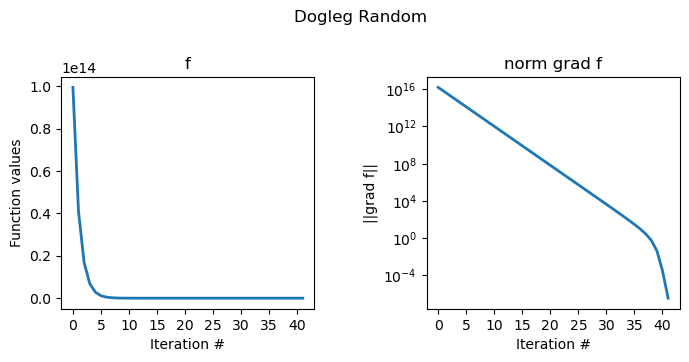

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

fig.tight_layout(pad=5)
plt.rcParams.update({'font.size': 10})
plt.suptitle("Dogleg Random")
# ax1.figure(figsize=(8,8))
ax1.plot(np.arange(iter),fvals[0:iter],linewidth = 2)
ax1.set_xlabel("Iteration #")
ax1.set_ylabel("Function values")
ax1.set_title("f")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.figure(figsize=(4,4))
ax2.plot(np.arange(iter),ngvals[0:iter],linewidth = 2)
ax2.set_xlabel("Iteration #")
ax2.set_ylabel("||grad f||")
ax2.set_yscale("log")
ax2.set_title("norm grad f")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

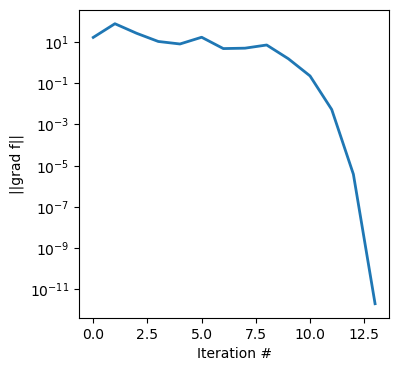

In [30]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(4,4))
plt.plot(np.arange(iter),ngvals[0:iter],linewidth = 2)
plt.xlabel("Iteration #")
plt.ylabel("||grad f||")
plt.yscale("log")

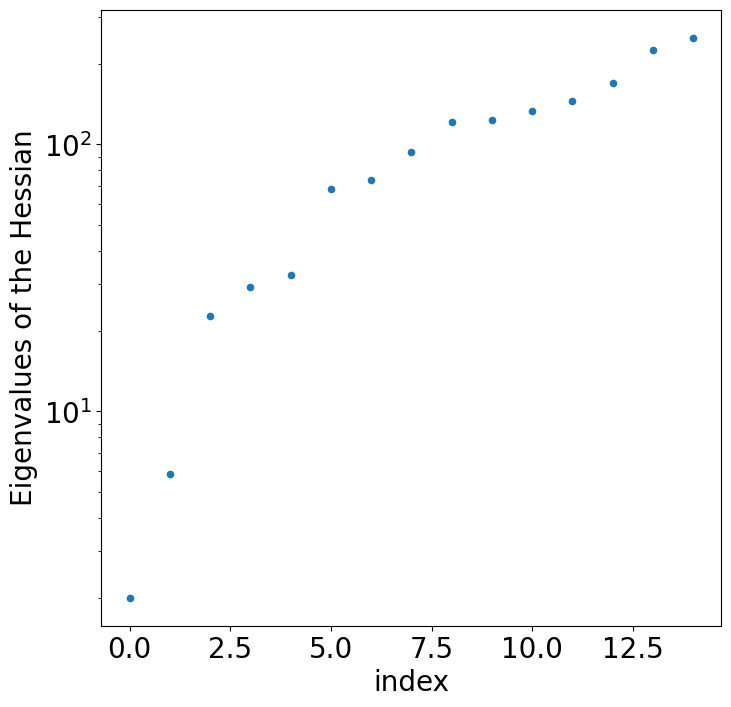

In [10]:
plt.rcParams.update({'font.size': 20})
H = LJhess(x)
evals = np.sort(np.linalg.eigvals(H))
plt.figure(figsize=(8,8))
plt.scatter(np.arange(np.size(x)),evals,s = 20)
plt.xlabel("index")
plt.ylabel("Eigenvalues of the Hessian")
if( evals[0] > 0 ):
    plt.yscale("log")
